# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Градиентный бустинг (XGBoost)
7. Feature Importance
8. Написание своих реализаций (классы)
9. Подведение итогов


## О командe

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Усов С.Е.         | 307    | Solo way       | Все сам                      |

 Датасет: [abalone](https://code.datasciencedojo.com/zhangyuan/datasets/tree/master/Abalone)

## Описание датасета

Этот набор данных содержит физические измерения морских улиток — абалонов — и используется для предсказания их возраста. Возраст определяется по количеству колец на раковине, что требует разрезания, окрашивания и подсчёта под микроскопом — трудоёмкая и скучная процедура. Цель задачи — научиться предсказывать возраст (количество колец) по более легко измеримым физическим характеристикам, таким как размеры и веса. 

Данные отлично подходят для практики в разведочном анализе (EDA), визуализации, а также в построении моделей классификации и регрессии. Несмотря на кажущуюся простоту, задача может оказаться нетривиальной из-за нелинейных зависимостей, асимметричного распределения возраста и категориального признака пола. 

---

### Таблица признаков датасета "Abalone"

| № | Признак | Тип данных | Описание |
|---|---|---|---|
| 1 | **Sex** | categorical | Пол абалона (M: самец, F: самка, I: детеныш) |
| 2 | **Length** | float | Длина раковины (наибольшее измерение в мм) |
| 3 | **Diameter** | float | Диаметр раковины (перпендикулярно длине в мм) |
| 4 | **Height** | float | Высота раковины (с мясом внутри в мм) |
| 5 | **Whole weight** | float | Общий вес абалона (в граммах) |
| 6 | **Shucked weight** | float | Вес мяса без раковины (в граммах) |
| 7 | **Viscera weight** | float | Вес внутренностей после очистки (в граммах) |
| 8 | **Shell weight** | float | Вес высушенной раковины (в граммах) |
| 9 | **Rings** (target) | integer | Количество колец на раковине (возраст = кольца + 1.5 года) |


## 0. Глобальная настройка проекта


In [1]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1. Подготовка данных + Feature Tuning

### 1.1. Загрузка датасета

Подключим библиотеки, для предобработки данных

In [2]:
import pandas as pd
import numpy as np


Загрузка датасета `pd.read_csv(path_to_dataset: str)`

In [3]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

file_path = 'abalone_data.csv'

df = pd.read_csv(file_path, names=column_names, header=None)

Посмотрим первые три строки датасета `df.head(n: int)`

In [4]:
df.head(3)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9


Атрибут sex (пол): Этот признак имеет текстовые категориальные значения (M, F, I). Большинство алгоритмов машинного обучения работают только с числами, поэтому этот столбец нельзя использовать в исходном виде `Sex`. Преобразовать в числовой формат методом one-hot encoding (создание отдельных столбцов для каждой категории).

In [5]:
# One-hot encoding для признака Sex
sex_encoded = pd.get_dummies(df['Sex'], prefix='Sex', dtype=int)
df_encoded = pd.concat([df.drop('Sex', axis=1), sex_encoded], axis=1)

In [6]:
print("Данные после one-hot encoding:")
df_encoded.head(3)

Данные после one-hot encoding:


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9,1,0,0


### 1.2. Сбор основной информации

Получение общей информации `df_encoded.info()`

In [6]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole weight    4177 non-null   float64
 4   Shucked weight  4177 non-null   float64
 5   Viscera weight  4177 non-null   float64
 6   Shell weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   Sex_F           4177 non-null   int64  
 9   Sex_I           4177 non-null   int64  
 10  Sex_M           4177 non-null   int64  
dtypes: float64(7), int64(4)
memory usage: 359.1 KB


Получение всей статистики `df_encoded.describe()`

In [7]:
df_encoded.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,0.312904,0.321283,0.365813
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,0.463731,0.467025,0.481715
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


**Вывод:**

1. **Общая информация**

    * **Размер датасета**: 4177 наблюдений (морских улиток).
    * **Целевая переменная (Rings)**: принимает значения от **1 до 29**, со средним ≈ **9.93**.
    
        -> Возраст улиток варьируется от 1 года (молодые особи) до 29 лет (старые), но большинство улиток имеют возраст **8–11 лет** (25%–75% перцентили).
        -> Распределение возраста симметричное (медиана 9.0), стандартное отклонение 3.22 — улитки в основном не слишком молодые и не очень старые.

2. **Размеры тела**

    * **Length (длина)**:
        * Среднее ≈ 0.52, разброс значительный (от 0.075 до 0.815).
        * Большинство улиток имеют длину в диапазоне **0.45–0.615** (25%–75% перцентили).
        * Минимальное значение (0.075) соответствует очень молодым особям, максимальное (0.815) — крупным взрослым.

    * **Diameter (диаметр)**:
        * Среднее ≈ 0.408, минимальное 0.055, максимальное 0.65.
        * Основная масса улиток имеет диаметр **0.35–0.48** (25%–75% перцентили).
        * Соотношение длины к диаметру ≈ 1.3:1 — типично для раковин моллюсков.

    * **Height (высота)**:
        * Среднее ≈ 0.14, но **максимальное значение 1.13 — аномально высокое** (в 8 раз больше медианы 0.14).
        * Минимальное значение **0 — физически невозможно** для живой улитки (вероятно, ошибка в данных или незаполненные значения).
        * Большинство улиток имеют высоту **0.115–0.165**, но есть экстремальные выбросы, требующие проверки.

3. **Весовые характеристики**

    * **Whole weight (общий вес)**:
        * Среднее ≈ 0.83, стандартное отклонение 0.49 — сильный разброс.
        * Минимальное значение **0.002** (микроскопические особи) vs максимальное **2.8255** (крупные улитки).
        * Большинство улиток весят **0.44–1.15** — вес коррелирует с возрастом (Rings), но есть редкие экземпляры с аномально высоким весом.

    * **Shell weight (вес раковины)**:
        * Среднее ≈ 0.24, медиана 0.234 — раковина составляет ~25% от общего веса.
        * Вес раковины в основном **0.13–0.33**, что соответствует здоровому росту. Высокие значения (>0.5) могут указывать на старые особи.

    * **Shucked weight (вес мяса)** и **Viscera weight (вес внутренностей)**:
        * Мясо составляет ~43% от общего веса (Shucked weight среднее 0.36), внутренности — ~22% (Viscera weight среднее 0.18).
        * Соотношение мяса к внутренностям ≈ 2:1 — типично для моллюсков. Высокие значения Viscera weight (>0.5) могут быть связаны с размножением.

4. **Пол (Sex)**

    * **Распределение по полу**:
        * **Sex_M (мужские)**: 36.6% (среднее 0.366) — наиболее распространенная категория.
        * **Sex_I (неопределенные)**: 32.1% (среднее 0.321) — молодые особи, пол еще не определен.
        * **Sex_F (женские)**: 31.3% (среднее 0.313) — немного реже мужских.
    
    * **Вывод**: Пол распределен почти равномерно, что важно для анализа (нет дисбаланса). Неопределенные особи (Sex_I) составляют треть датасета — возможно, это данные о молодых улитках до полового созревания.

Проверка на пропуски данных `df_encoded.isnull().sum()`

In [8]:
print(df_encoded.isnull().sum())

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
Sex_F             0
Sex_I             0
Sex_M             0
dtype: int64


**Вывод:** в датасете нет пропусков!

Посмотрим на распределение целевой переменной

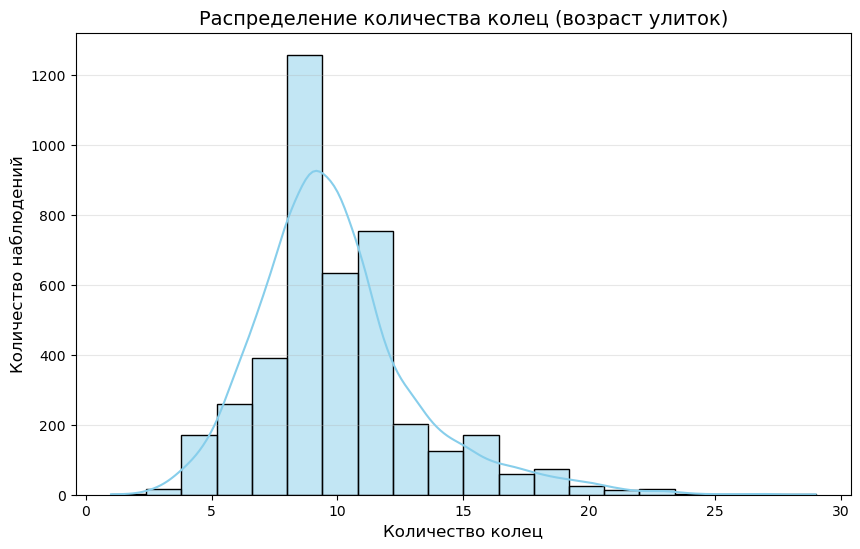

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_encoded, 
    x='Rings', 
    kde=True,
    bins=20,
    color='skyblue'
)
plt.title('Распределение количества колец (возраст улиток)', fontsize=14)
plt.xlabel('Количество колец', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()


**Вывод:** 

Размер датасета: 4177 наблюдений (морских улиток).        
Целевая переменная (Rings): принимает значения от 1 до 29, со средним ≈ 9.93. 
-> Возраст улиток в основном сосредоточен в диапазоне 8–11 лет (25%–75% перцентили), медиана = 9.0. 
-> Распределение симметричное и сбалансированное — нет значительного перекоса в сторону молодых или старых особей. Это идеально для задач регрессии, так как все возрастные группы представлены достаточно равномерно. 
         
     

Посмотрим на корреляцию данных.

***Определение 1: Корреляция данных — это статистическая мера, показывающая, насколько и в каком направлении связаны между собой две переменные.***

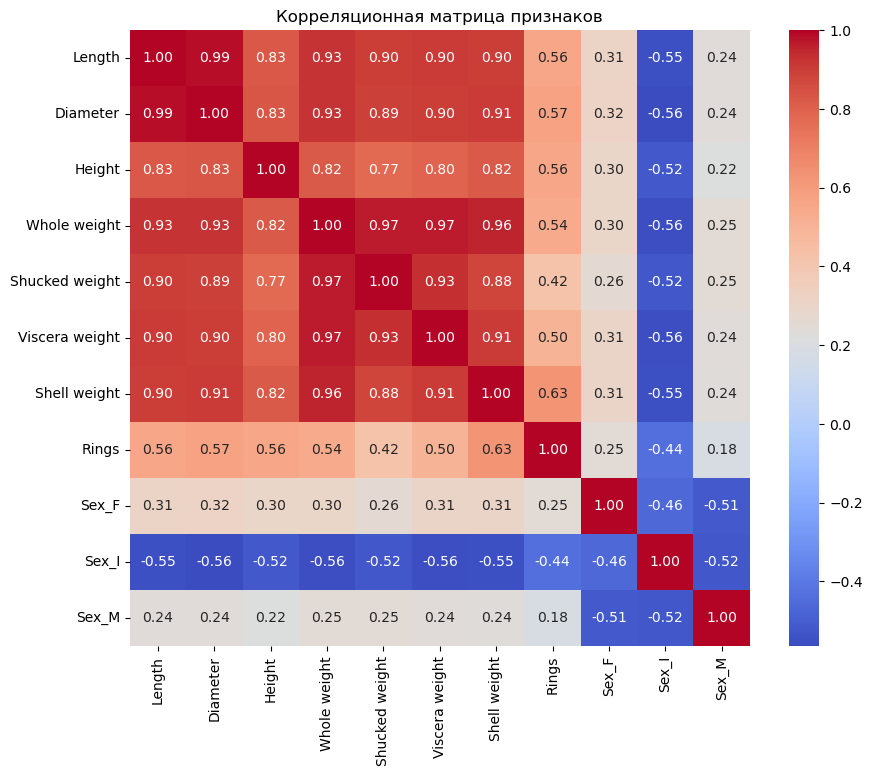

In [10]:
def draw_corr_matrix(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

draw_corr_matrix(df_encoded)

**Анализ корреляционной матрицы:**

1. **Сильные положительные корреляции**  
   - **Размеры тела**:  
     `Length` ↔ `Diameter` (**0.99**), `Length` ↔ `Whole weight` (**0.93**), `Diameter` ↔ `Whole weight` (**0.93**) — улитки с большими размерами имеют больший общий вес.  
     Это логично: рост улитки пропорционален увеличению всех её параметров.  

   - **Весовые характеристики**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**), `Shell weight` ↔ `Whole weight` (**0.96**) — общая масса улитки зависит от веса мяса (`Shucked weight`) и раковины (`Shell weight`).  

2. **Корреляции с целевой переменной (Rings)**  
   - **Наибольшая связь**:  
     `Shell weight` ↔ `Rings` (**0.63**) — чем старше улитка, тем тяжелее её раковина. Это ключевой признак для предсказания возраста.  
     `Whole weight` ↔ `Rings` (**0.56**) — общий вес также растёт с возрастом, но медленнее, чем вес раковины.  

   - **Слабые связи**:  
     `Viscera weight` ↔ `Rings` (**0.45**) — внутренние органы растут, но не пропорционально возрасту.  
     `Sex_*` ↔ `Rings` (**−0.44 до −0.52**) — женские и молодые улитки (`Sex_F`, `Sex_I`) чаще встречаются в более молодых возрастных группах.  

3. **Мультиколлинеарность**  
   - **Размеры тела**:  
     `Length`, `Diameter`, `Height` коррелируют выше **0.8** — их использование вместе в линейных моделях приведёт к нестабильности коэффициентов.

   - **Весовые признаки**:  
     `Whole weight` ↔ `Shucked weight` (**0.97**) — информация дублируется.  

4. **Отрицательные корреляции**  
   - `Sex_M` ↔ `Sex_F` (**−0.56**), `Sex_I` ↔ `Sex_M` (**−0.52**) — улитки не могут быть одновременно мужскими и женскими/иммартурными.

---

- **Основные признаки для модели линейной регрессии**: `Shell weight`, `Length`.  

### 1.3. Подготовка датасета под разные задачи

#### 1.3.1 Линейная регрессия (Linear Regression / Ridge / Lasso)

**Особенности модели:**

- Чувствительна к масштабу признаков и мультиколлинеарности.
- Чувствительна к выбросам.

Разделение датасета на свойства и целевую переменную

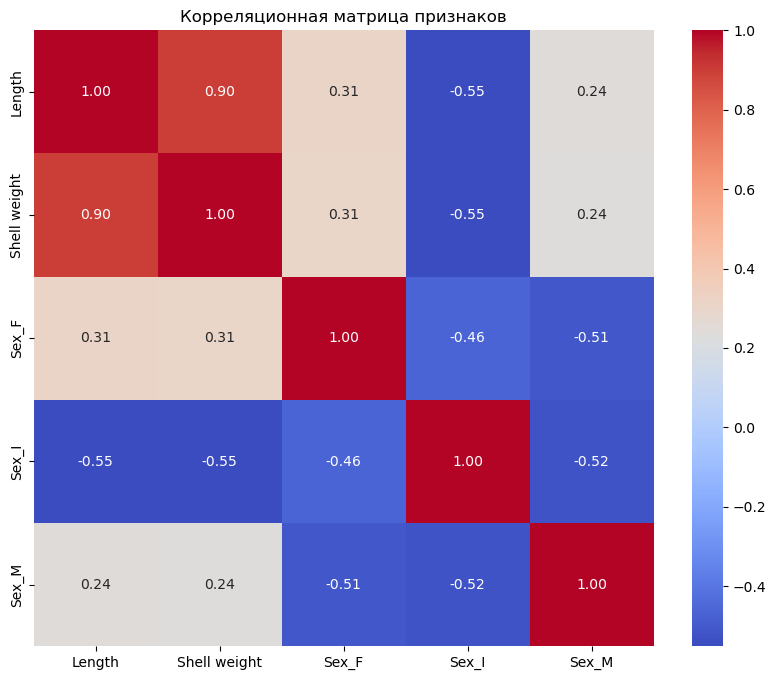

In [11]:
selected_features = ['Length', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']
X_linear = df_encoded[selected_features]
Y_linear = df_encoded['Rings']

draw_corr_matrix(X_linear)


Здесь довольно большая корреляция между Length и Shell Weight, но это нормально, поскольку они отражают важные физические характеристики.

Добавим функцию проверки на выбросы данных.

In [12]:
def check_outliers(df, columns=None, title=""):
    if columns is None:
        columns = df.select_dtypes(include='number').columns
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        print(f"\n{title}{col}: {len(outliers)} выбросов ({len(outliers)/len(df)*100:.1f}%)")
        print(f"Границы: [{lower_bound:.4f}, {upper_bound:.4f}]")
        
        # Визуализация
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'{col} | Выбросы: {len(outliers)}')
        plt.show()

Визуализируем целевую переменную - Y и набор свойств - X. Также подготовим заранее разделение на Train/Test. Скошенность бинарных данных - пол, не требует дальнейшей трансформации.

In [13]:
from sklearn.model_selection import train_test_split

skew_values_X_linear = X_linear.skew()
skew_values_hard = skew_values_X_linear[abs(skew_values_X_linear) > 0.5]  # выделяем сильноскошенные данные
print(skew_values_hard)  # сильно скошенные

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы Свойств: {skew_columns_hard}')

y_skew = Y_linear.skew()
print(f"\nСкошенность целевой переменной (Rings): {y_skew:.4f}")
if abs(y_skew) > 0.5:
    print("Целевая переменная сильно скошена!")
else:
    print("Целевая переменная не сильно скошена!")

X_linear_train, X_linear_test, Y_linear_train, Y_linear_test = train_test_split(
    X_linear, Y_linear, test_size=0.2, random_state=RND_SEED)

Length         -0.639873
Shell weight    0.620927
Sex_F           0.807302
Sex_I           0.765708
Sex_M           0.557390
dtype: float64
Скошенные столбцы Свойств: ['Length', 'Shell weight', 'Sex_F', 'Sex_I', 'Sex_M']

Скошенность целевой переменной (Rings): 1.1141
Целевая переменная сильно скошена!


Проверим X_linear_train и Y_linear_train на выбросы.


X_linear_train (до): Length: 41 выбросов (1.2%)
Границы: [0.2025, 0.8625]


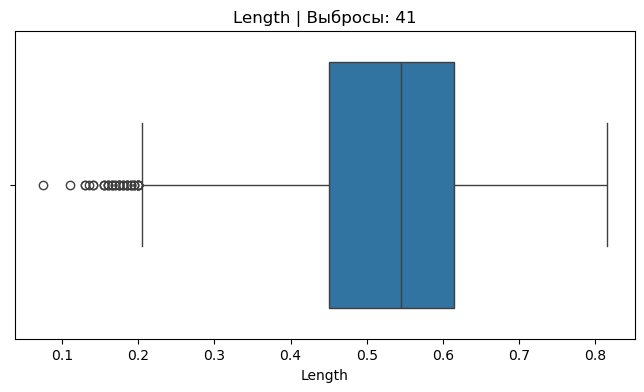


X_linear_train (до): Shell weight: 26 выбросов (0.8%)
Границы: [-0.1700, 0.6300]


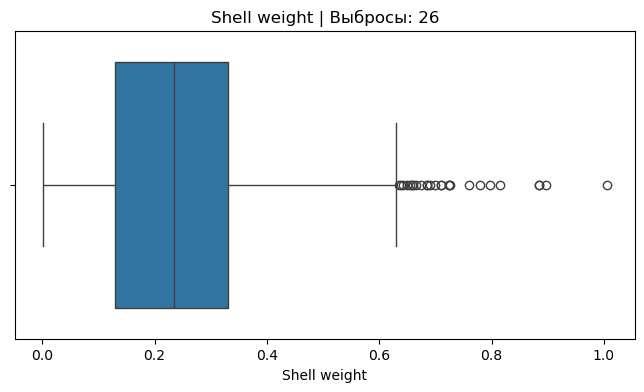


X_linear_train (до): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


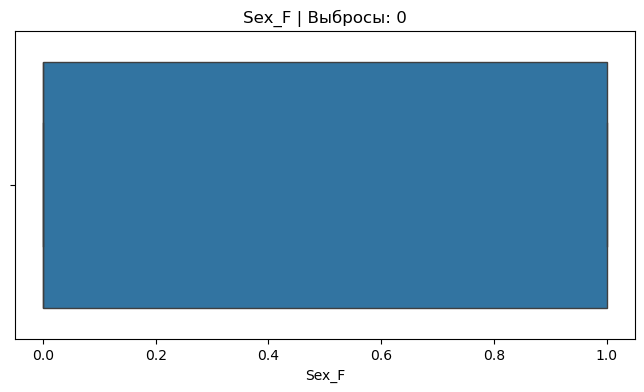


X_linear_train (до): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


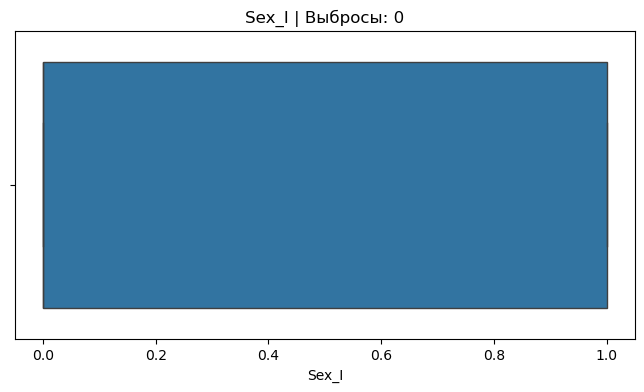


X_linear_train (до): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


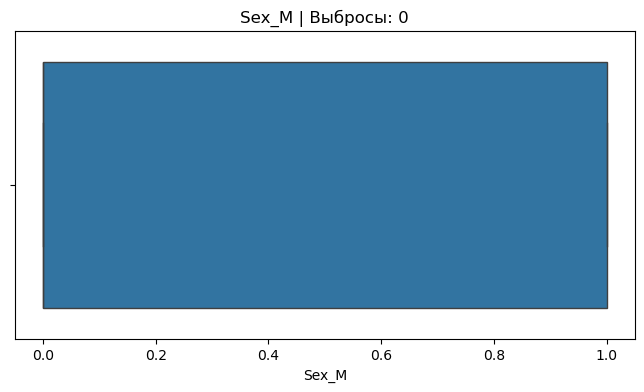


Y_linear_train (до): Rings: 210 выбросов (6.3%)
Границы: [3.5000, 15.5000]


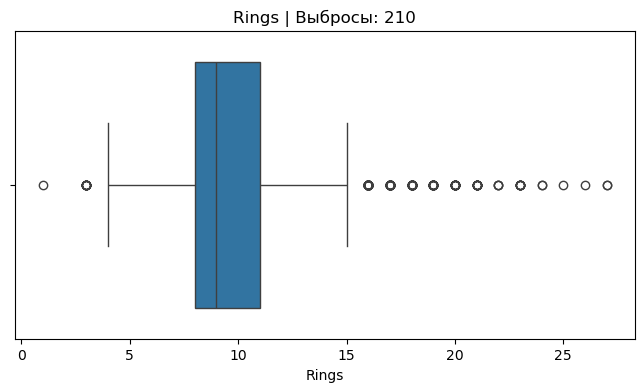

In [14]:
check_outliers(X_linear_train, title="X_linear_train (до): ")

check_outliers(pd.DataFrame(Y_linear_train, columns=['Rings']), title="Y_linear_train (до): ")

Исправим данные для свойства - Shell Weight и целевой переменной Rings. Править для других не имеет смысла, поскольку процент очень незначителен от общего числа.

In [24]:
X_linear_train['Shell weight'] = X_linear_train['Shell weight'].apply(lambda x: 0 if x < 0 else x)

mask = Y_linear_train >= 3.5  # Оставляем только Rings >= 3.5

X_linear_train = X_linear_train.loc[mask]
Y_linear_train = Y_linear_train[mask]

Трансформация целевой переменной Y.

In [25]:
from sklearn.preprocessing import PowerTransformer

pt_y_linear = PowerTransformer(method='yeo-johnson')
y_linear_train_transformed = pt_y_linear.fit_transform(Y_linear_train.values.reshape(-1, 1)).flatten()
y_linear_test_transformed = pt_y_linear.transform(Y_linear_test.values.reshape(-1, 1)).flatten()

Проверка целевой переменной Y после трансформации.


Скошенность Y после трансформации:
Train: -0.0042
Test:  -0.1450


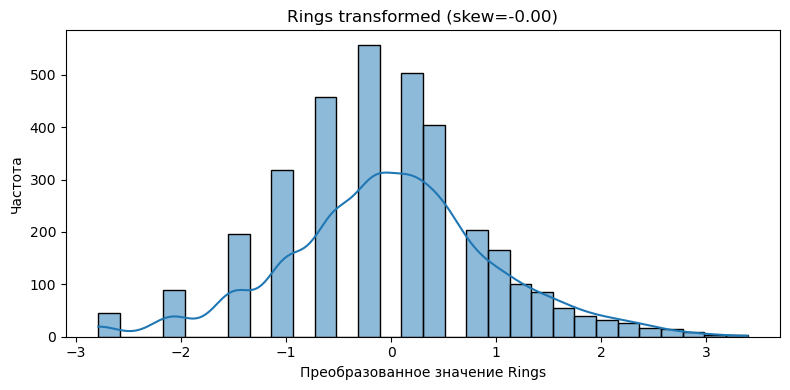

In [41]:
print("\nСкошенность Y после трансформации:")
print(f"Train: {pd.Series(y_linear_train_transformed).skew():.4f}")
print(f"Test:  {pd.Series(y_linear_test_transformed).skew():.4f}")

plt.figure(figsize=(8, 4))
sns.histplot(y_linear_train_transformed, kde=True, bins=30)
plt.title(f'Rings transformed (skew={pd.Series(y_linear_train_transformed).skew():.2f})')
plt.xlabel('Преобразованное значение Rings')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Теперь скошенность находится в хорошем состоянии. Нет явных выбросов.


Трансформация свойств - X.

In [38]:
from sklearn.preprocessing import StandardScaler

transform_features = ['Length', 'Shell weight']

X_train_transform = X_linear_train[transform_features]
X_test_transform = X_linear_test[transform_features]

pt_X_linear = PowerTransformer(method='yeo-johnson')
X_train_transformed = pt_X_linear.fit_transform(X_train_transform)
X_test_transformed = pt_X_linear.transform(X_test_transform)

X_linear_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=transform_features,
    index=X_linear_train.index
)
X_linear_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=transform_features,
    index=X_linear_test.index
)

X_linear_train_transformed = pd.concat([
    X_linear_train_transformed,
    X_linear_train.drop(columns=transform_features)
], axis=1)

X_linear_test_transformed = pd.concat([
    X_linear_test_transformed,
    X_linear_test.drop(columns=transform_features)
], axis=1)

scaler = StandardScaler()
X_linear_train_scaled = scaler.fit_transform(X_linear_train_transformed)
X_linear_test_scaled = scaler.transform(X_linear_test_transformed)

Проверка свойств X после трансформации.

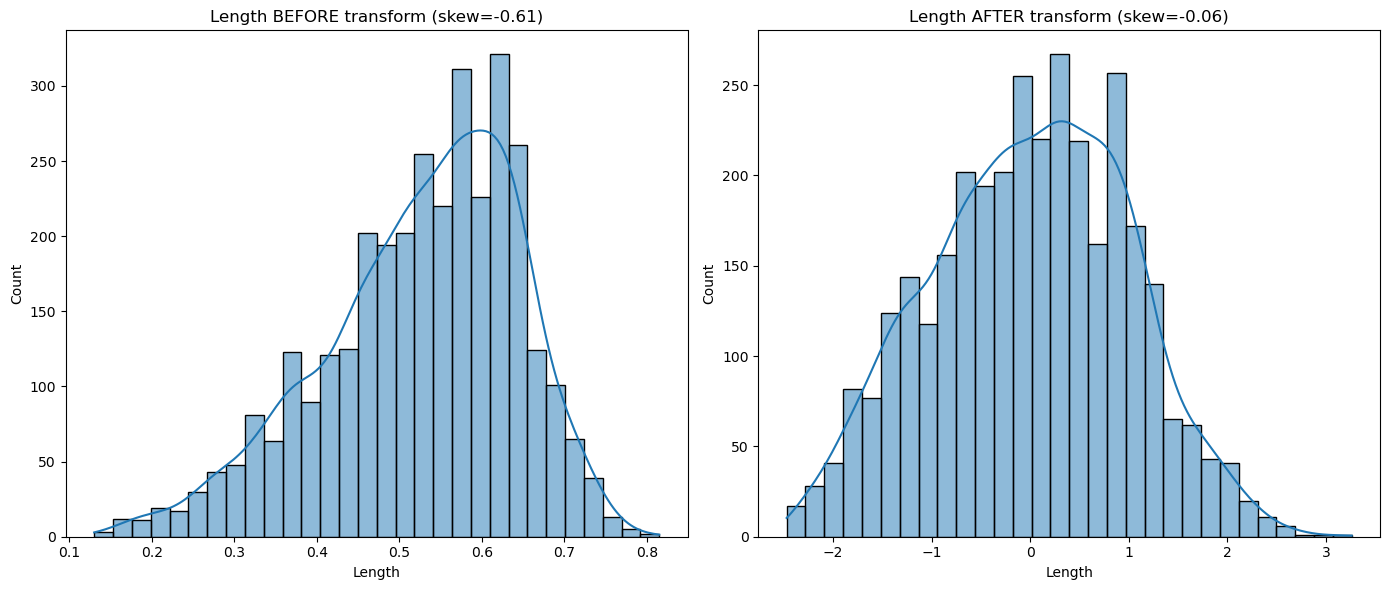

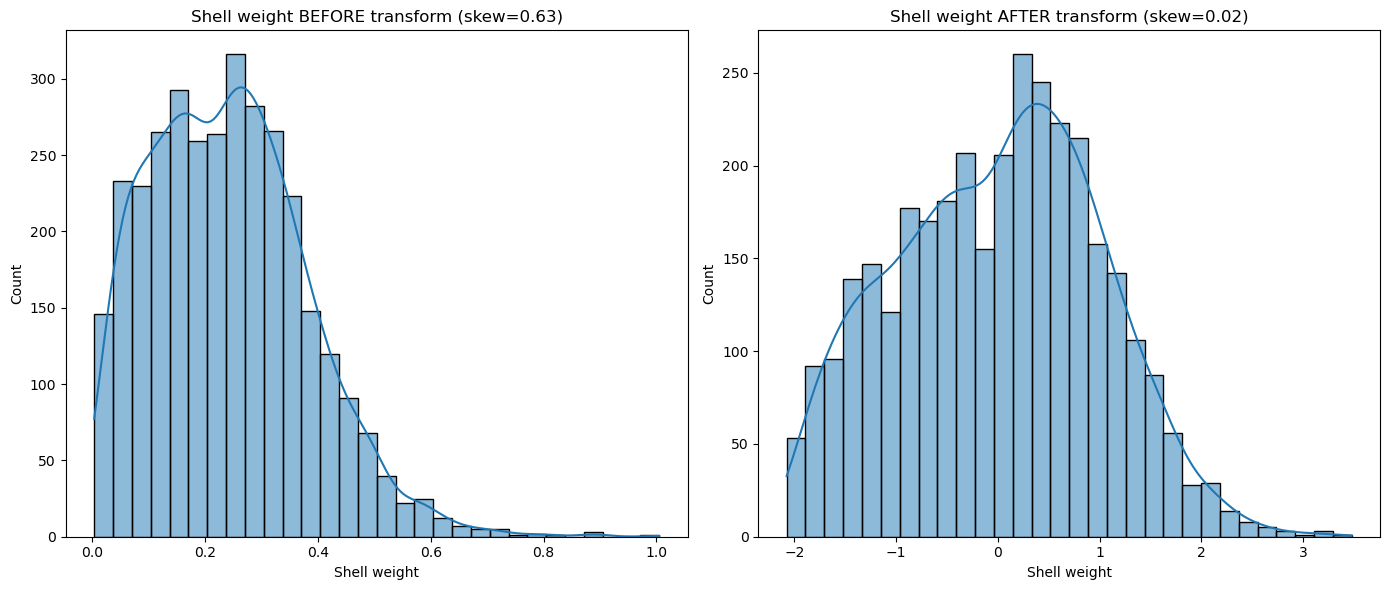


X_linear_train (после): Length: 2 выбросов (0.1%)
Границы: [-2.8670, 2.9027]


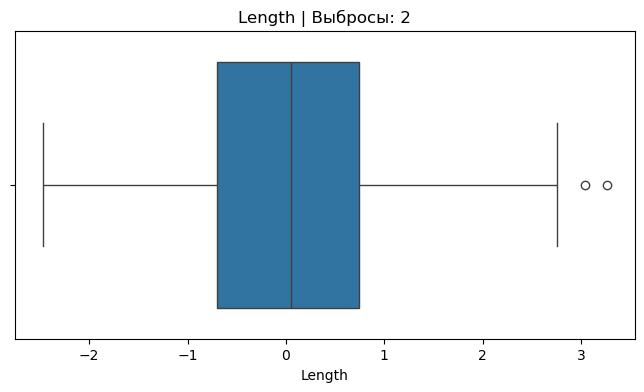


X_linear_train (после): Shell weight: 4 выбросов (0.1%)
Границы: [-3.0046, 2.9702]


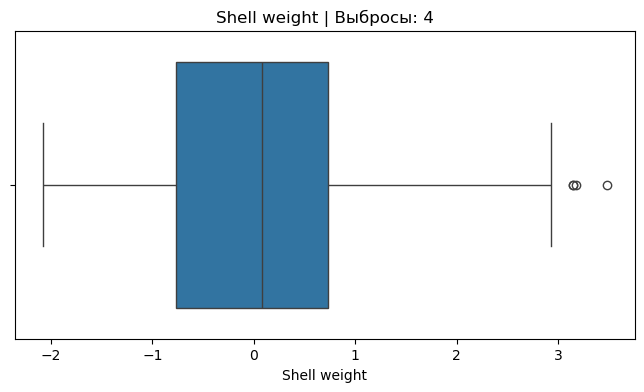


X_linear_train (после): Sex_F: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


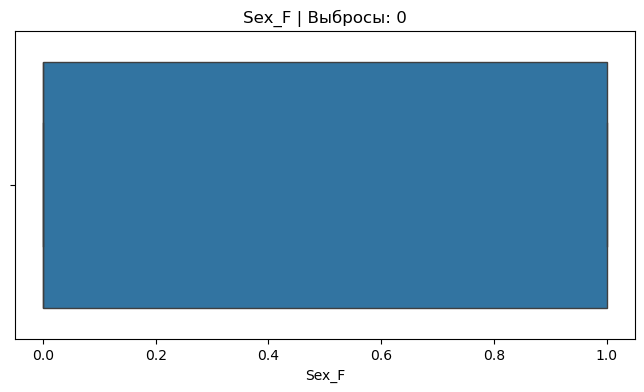


X_linear_train (после): Sex_I: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


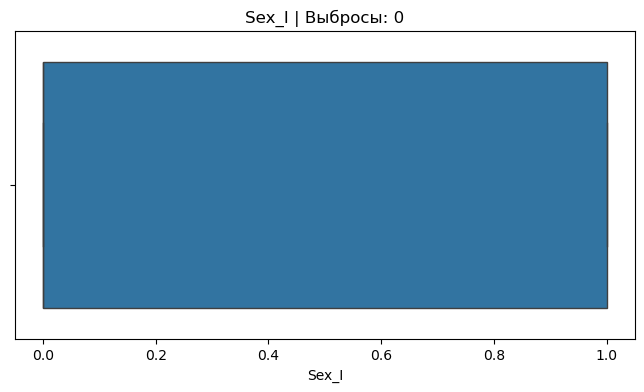


X_linear_train (после): Sex_M: 0 выбросов (0.0%)
Границы: [-1.5000, 2.5000]


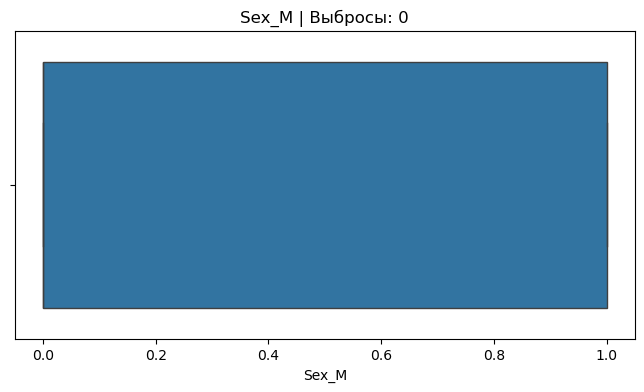

In [39]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Length'], kde=True, bins=30)
plt.title(f'Length BEFORE transform (skew={X_linear_train["Length"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Length'], kde=True, bins=30)
plt.title(f'Length AFTER transform (skew={X_linear_train_transformed["Length"].skew():.2f})')
plt.tight_layout()
plt.show()

# Визуализация Shell weight
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(X_linear_train['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight BEFORE transform (skew={X_linear_train["Shell weight"].skew():.2f})')

plt.subplot(1, 2, 2)
sns.histplot(X_linear_train_transformed['Shell weight'], kde=True, bins=30)
plt.title(f'Shell weight AFTER transform (skew={X_linear_train_transformed["Shell weight"].skew():.2f})')
plt.tight_layout()
plt.show()

check_outliers(X_linear_train_transformed, title="X_linear_train (после): ")


#### 1.3.2 Random Forest Regressor

**Особенности модели:**

* Не чувствительна к масштабу признаков.
* Может обрабатывать сильные корреляции между признаками.
* Может использовать категориальные признаки, если они закодированы как числовые.


Сделаем копию датасета

In [ ]:
df_forest = df_encoded.copy()

Feature engineering

In [ ]:
df_forest['shell_ratio'] = df_forest['Shell weight'] / df_forest['Whole weight']
df_forest['viscera_to_shucked'] = df_forest['Viscera weight'] / df_forest['Shucked weight']

df_forest['density'] = df_forest['Whole weight'] / (
    df_forest['Length'] * df_forest['Diameter'] * df_forest['Height']
).replace(0, np.nan)  # Заменяем 0 на NaN, чтобы избежать деления на ноль
df_forest['density'] = df_forest['density'].fillna(0)  # Заменяем NaN на 0

df_forest = df_forest.drop(columns=[
    'Shell weight', 
    'Whole weight', 
    'Viscera weight', 
    'Shucked weight', 
    'Length', 
    'Diameter', 
    'Height'
])

Разделение выборки

In [ ]:
X_forest = df_forest.drop(columns=['Rings'])  # Признаки (все кроме целевой переменной)
y_forest = df_forest['Rings']  # Целевая переменная

X_forest_train, X_forest_test, y_forest_train, y_forest_test = train_test_split(
    X_forest, y_forest, 
    test_size=0.2, 
    random_state=RND_SEED
)

#### 1.3.3 XGBoost

**Особенности модели:**

* Градиентный бустинг деревьев.
* Не чувствителен к масштабу.
* Может обрабатывать коррелированные признаки, но слишком много слабых признаков может замедлить обучение.

Сделаем копию датасета

In [14]:
df_xgboost = df_encoded.copy()

Feature engineering

In [ ]:
df_xgboost['shell_ratio'] = df_xgboost['Shell weight'] / df_xgboost['Whole weight']
df_xgboost['viscera_to_shucked'] = df_xgboost['Viscera weight'] / df_xgboost['Shucked weight']

volume = df_xgboost['Length'] * df_xgboost['Diameter'] * df_xgboost['Height']
df_xgboost['density'] = df_xgboost['Whole weight'] / volume.replace(0, np.nan)
df_xgboost['density'] = df_xgboost['density'].fillna(0)

df_xgboost['length_to_diameter'] = df_xgboost['Length'] / df_xgboost['Diameter']
df_xgboost['shucked_to_shell'] = df_xgboost['Shucked weight'] / df_xgboost['Shell weight']

Разделение выборки

In [17]:
from sklearn.model_selection import train_test_split

X_xgboost = df_xgboost.drop('Rings', axis=1)
y_xgboost = df_xgboost['Rings']

X_xgboost_train, X_xgboost_test, y_xgboost_train, y_xgboost_test = train_test_split(
    X_xgboost, y_xgboost, 
    test_size=0.2, 
    random_state=RND_SEED
)


## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

**Как интерпретировать**

| Метрика | Как читать                    | Что значит для анализа                                                   |
| ------- | ----------------------------- | ------------------------------------------------------------------------ |
| MSE     | Чем меньше, тем точнее        | Показывает среднюю квадратичную ошибку. Выбросы сильно влияют.           |
| RMSE    | В тех же единицах, что и цель | Удобно для прямой интерпретации ошибок.                                  |
| MAE     | Средняя абсолютная ошибка     | Устойчивее к выбросам, показывает среднюю фактическую ошибку.            |
| R²      | 0–1 (или <0)                  | 1 — идеальное совпадение, 0 — предсказывает среднее, <0 — хуже среднего. |

**Пример анализа:**

* Если RMSE и MAE сильно отличаются → есть выбросы.
* Если R² близок к 1 → модель хорошо объясняет вариацию данных.
* Можно сравнивать модели: линейная, RF, XGBoost. Та, у которой меньше RMSE/MAE и выше R² — более точная.


In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }


Прежде чем начнем обучать, создадим `DataFrame` для снятия метрик

In [ ]:
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R²'])

metrics_df.head()

## 3. Базовая модель линейной регрессии (аналитическое решение)

In [ ]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
# Обучение
lr.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr.predict(X_test_linear_scaled)
lr_metrics = get_metrics(y_test_linear, y_pred)
lr_metrics

## 4. Улучшенная версия линейной регрессии

In [ ]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [ ]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [ ]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_test_linear_scaled)
lr_gd_metrics = get_metrics(y_test_linear, y_pred)
lr_gd_metrics

### 4.2. Стохастический градиентный спуск

In [ ]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [ ]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_test_linear_scaled)
lr_sgd_metrics = get_metrics(y_test_linear, y_pred)
lr_sgd_metrics

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [ ]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [ ]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_test_linear_scaled)
lr_ridge_metrics = get_metrics(y_test_linear, y_pred)
lr_ridge_metrics

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [ ]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [ ]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_test_linear_scaled)
lr_lasso_metrics = get_metrics(y_test_linear, y_pred)
lr_lasso_metrics

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [ ]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [ ]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_train_linear)

In [ ]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_test_linear_scaled)
lr_enet_metrics = get_metrics(y_test_linear, y_pred)
lr_enet_metrics

## 4. Случайный лес регрессор

In [ ]:
# Инициализация модели
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [ ]:
# Обучение
rf.fit(X_train_forest, y_train_forest)

In [ ]:
# Прогонка и метрики
y_pred = rf.predict(X_test_forest)
rf_metrics = get_metrics(y_test_forest, y_pred)
rf_metrics

## 5. Градиентный бустинг (XGBoost)

In [ ]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [ ]:
# Обучение
xgb.fit(X_train_xgboost, y_train_xgboost)

In [ ]:
# Прогонка и метрики
y_pred = xgb.predict(X_test_xgboost)
xgb_metrics = get_metrics(y_test_xgboost, y_pred)
xgb_metrics

## 5. Feature Importance

### 5.1 Linear Regression


В **линейных моделях** (LinearRegression, Ridge, Lasso) **feature importance** — это не что иное, как **коэффициенты модели (`coef_`)**.

Но есть нюансы:

* Коэффициенты сами по себе могут быть несопоставимы по масштабу признаков.
* Поэтому мы правильно сделали **стандартизацию (StandardScaler)** → теперь коэффициенты отражают вклад признаков.
* Знак коэффициента (+ / -) показывает направление влияния:

  * `+` → признак увеличивает предсказание качества вина,
  * `-` → уменьшает.


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

### 5.2 Linear Regression (GD)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)


In [ ]:
importance = pd.DataFrame({
    'Feature': X_train_linear.columns,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest


In [ ]:
feature_importances = pd.Series(rf.feature_importances_, index=X_forest.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

### 5.6 XGBoost

In [ ]:
plt.figure(figsize=(10,6))
xgboost.plot_importance(xgb, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

## 8. Написание своих реализаций (классы)

Напишите свои классы реализации:

- LR
- LR + GD
- LR + SGD
- *Random Forest (не обязательно)
- *Gradient Boosting Regressor (не обязательно)

## 9. Итоги

Что сделать?

1. Сгрупировать все метрики, и выяснить, какой методо сработал лучше всего и почему?
2. Ответить на вопросы:

    1. Что такое регрессия и чем она отличается от классификации?
    2. Какова целевая переменная в задаче регрессии?
    3. Зачем нужно масштабирование признаков перед обучением линейной регрессии?
    4. Что означает коэффициент признака в линейной регрессии?
    5. Что такое MSE, RMSE, MAE и R², и чем они отличаются?
    6. В чем разница между Ridge и Lasso регуляризацией?
    7. Почему деревья решений и Random Forest не требуют стандартизации признаков?
    8. Что такое мультиколлинеарность и почему она мешает линейной регрессии?
    9. Как можно уменьшить влияние выбросов на линейную регрессию?
    10. Какие гиперпараметры наиболее важны для Random Forest Regressor?
    11. Какие гиперпараметры наиболее важны для XGBoost в задаче регрессии?
    12. Что значит глубина дерева (max\_depth) и как она влияет на модель?
    13. Зачем нужен `learning_rate` в градиентном бустинге?
    14. Как можно оценить важность признаков (feature importance) в линейной регрессии, случайном лесу и XGBoost?
    15. Почему XGBoost часто работает лучше, чем Random Forest, на структурированных данных?
    16. Что такое переобучение и как его можно выявить на графике обучения?
    17. Как работает метод ансамблирования в Random Forest (bagging)?
    18. В чем отличие бустинга от бэггинга?
    19. Какие способы feature engineering можно применить к винному датасету (Wine Quality)?
    20. Как использовать кросс-валидацию для подбора гиперпараметров моделей регрессии?


#### 9.1. Группировка метрик

In [ ]:
# code here

#### 9.2. Ответы на вопросы

Вопрос:

Ответ: